This notebook visualizes CIFAR10 users using various methods of generating simulation users.

In [14]:
import os

import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import joblib
import torch

from ramsay.data.sampling import get_data_sampler
from polya_mixture.datasets.femnist_dataset import _load_h5_into_dict
from polya_mixture.datasets.sampler import DirichletDataSampler

from ramsay.internal.ops import pytorch_ops
from ramsay.internal.ops.selector import get_default_framework_module as get_ops
from ramsay.internal.ops.selector import set_framework_module

In [15]:
# Helper functions

def load_femnist_as_dict(data_dir):
    h5_file_path = os.path.join(data_dir, 'fed_emnist_train.h5')
    digits_only = False
    numpy_to_tensor = lambda x: x
    user_id_to_data = _load_h5_into_dict(h5_file_path, digits_only,
                                         numpy_to_tensor)
    return user_id_to_data

def get_all_labels(user_id_to_data):
    all_labels = []
    for _, y in user_id_to_data.values():
        all_labels.append(y)
    return np.hstack(all_labels)


def get_femnist_len_sampler(user_id_to_data):
    histo = np.zeros(500)
    for _, y in user_id_to_data.values():
        num_samples = len(y)
        histo[num_samples] += 1

    p = histo / sum(histo) 
    len_sampler = lambda p=p: np.random.choice(range(len(p)), p=p)
    return len_sampler

In [32]:
# Functions to generate users

def make_special_federated_dataset(h5_file_path, numpy_to_tensor):
    """
    Create federated dataset from a FEMNIST data file.
    Keep same label distribution per user, but mix up the datapoints.
    """
    user_id_to_data = _load_h5_into_dict(h5_file_path, False,
                                     numpy_to_tensor)
    user_ids = list(user_id_to_data.keys())
    images = np.vstack([data[0] for data in user_id_to_data.values()])

    labels = np.hstack([data[1]
                        for data in user_id_to_data.values()])
    unique_labels = np.unique(labels)
    indices_per_class = {
        i: np.random.permutation(np.nonzero(labels == i)[0])
        for i in unique_labels
    }

    new_user_id_to_data = dict()
    start_id_per_class = {i: 0 for i in unique_labels}
    #print('start_id_per_class', start_id_per_class)
    for user_id, data in user_id_to_data.items():
        #print('user_id', user_id)
        user_labels = data[1]
        #print('labels', labels)

        # sample images based off labels.
        sampled_data_idx = []
        for label in user_labels:
            #print('label', label)
            #print('start_id_per_class[label]', start_id_per_class[label])
            #print(' indices_per_class[label]', type(indices_per_class[label]), len(indices_per_class[label]))
            sampled_data_idx.append(
                indices_per_class[label][start_id_per_class[label]])
            start_id_per_class[label] += 1

        # TODO might need to ensure labels in not on cpu any more.
        new_user_id_to_data[user_id] = [images[sampled_data_idx], data[1]]

    return new_user_id_to_data

def generate_true_users(h5_file_path, numpy_to_tensor):
    user_id_to_data = make_special_federated_dataset(h5_file_path, numpy_to_tensor)
    users = []
    for _, y in user_id_to_data.values():
        labels, counts = np.unique(y, return_counts=True)
        full_y = np.zeros(62)
        full_y[labels] = counts
        users.append(full_y)
    return np.array(users)


def generate_mixture_users(num_users, alphas, phi, num_samples_dists, all_labels):
    users = []
    ks = []
    for _ in range(num_users):
        k = np.random.choice(range(len(alphas)), p=phi)
        d = num_samples_dists[k]
        n = np.random.choice(range(len(d)), p=d)

        sampler = DirichletDataSampler(alphas[k], all_labels)
        idxs = sampler(n)
        y = np.array(all_labels)[idxs]
        full_y = np.zeros(62)
        vals, count = np.unique(y, return_counts=True)
        full_y[vals] = count
        users.append(full_y)
    return np.array(users)

def generate_single_dirichlet_users(num_users, alpha, user_len_sampler, all_labels):
    sampler = DirichletDataSampler(alpha, all_labels)
    users = []
    for _ in range(num_users):
        n = user_len_sampler()
        idxs = sampler(n)
        y = np.array(all_labels)[idxs]
        full_y = np.zeros(62)
        vals, count = np.unique(y, return_counts=True)
        full_y[vals] = count
        users.append(full_y)
    return np.array(users)

def generate_uniform_users(num_users, user_len_sampler, all_labels):
    sampler = get_data_sampler('random', len(all_labels))
    users = []
    for _ in range(num_users):
        n = user_len_sampler()
        idxs = sampler(n)
        y = np.array(all_labels)[idxs]
        full_y = np.zeros(62)
        vals, count = np.unique(y, return_counts=True)
        full_y[vals] = count
        users.append(full_y)
    return np.array(users)

In [33]:
# create distributions
numpy_to_tensor=lambda x: x
train_h5_file_path = os.path.join(data_dir, 'fed_emnist_train.h5')
true_users = generate_true_users(train_h5_file_path, numpy_to_tensor)

In [34]:
# Load femnist and get all labels
data_dir = 'data/femnist'
user_id_to_data = load_femnist_as_dict(data_dir)
all_labels = get_all_labels(user_id_to_data)

# One mixture component

In [36]:
num_users = len(user_id_to_data.keys())

dict_keys(['alphas', 'phi'])


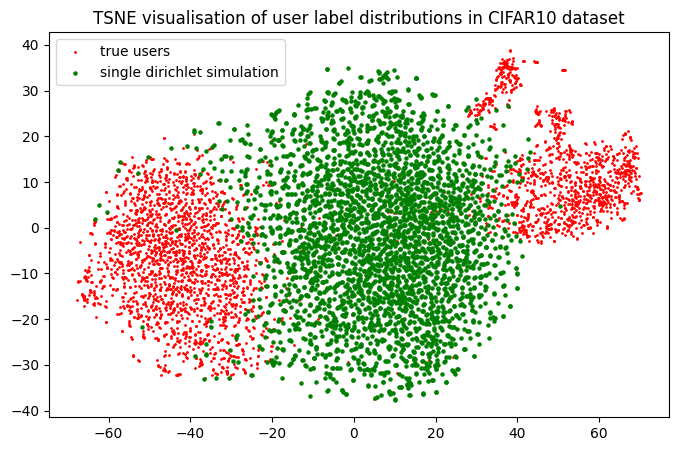

In [37]:
# Load single dirichlet saved params

# load learned parameters
params = joblib.load(os.path.join('mle_params', 'femnist_learn_dirichlet_uniform_datapoints_1_mixture', 'polya-mixture.joblib'))
print(params.keys())
alpha_one_component =  np.array(params['alphas'][0])

num_samples_distribution_one_component = joblib.load(os.path.join('num_samples_distribution', 'femnist_learn_dirichlet_uniform_datapoints_1_mixture.joblib'))
num_samples_distribution_one_component = num_samples_distribution_one_component.numpy().reshape(-1,)

len_sampler = lambda: np.random.choice(range(len(num_samples_distribution_one_component)), p=num_samples_distribution_one_component)

# create distributions
numpy_to_tensor=lambda x: x
train_h5_file_path = os.path.join(data_dir, 'fed_emnist_train.h5')
true_users = generate_true_users(train_h5_file_path, numpy_to_tensor)
simulated_single_dirichlet_users = generate_single_dirichlet_users(len(true_users), alpha_one_component, len_sampler, all_labels)
simulated_uniform_users = generate_uniform_users(len(true_users), len_sampler, all_labels)

# Run TSNE on the label counts of all users
tsne2 = TSNE(n_components=2)
X = np.vstack([true_users, simulated_single_dirichlet_users])#, simulated_uniform_users])
X = X / X.sum(axis=1, keepdims=True) # This will normalize the counts to proportions to ignore num sample per user effects
X_2dim = tsne2.fit_transform(X)

N = num_users
plt.figure(figsize=(8, 5))
plt.title('TSNE visualisation of user label distributions in CIFAR10 dataset')
plt.scatter(X_2dim[:N, 0], X_2dim[:N, 1], s=1, color='red', label='true users')
plt.scatter(X_2dim[N:2*N, 0], X_2dim[N:2*N, 1], s=5, color='green', label='single dirichlet simulation')
#plt.scatter(X_2dim[2*N:3*N, 0], X_2dim[2*N:3*N, 1], s=1, color='blue', label='Simulated users: partitioned uniformly randomly')
plt.legend(fontsize=10)

# Two mixture components

dict_keys(['alphas', 'phi'])
alpha_mixture [[16.750004  18.331835  16.044174  17.069632  15.618997  14.15745
  16.104206  16.819046  16.03719   15.955028   5.146734   3.0246813
   9.8258095  3.5644112  2.7141812  8.936298   1.5904485  2.0354161
  11.45639    2.881548   1.5424834  3.8086164  8.787516   6.9708943
  27.304955   8.241547   1.5641342  2.9246576 22.530138   8.777699
  13.190252   3.7291086  4.066346   1.7287781  3.954448   1.642856
   9.62832    4.608186   1.7004721 10.12116   25.137959   1.5616059
   2.9377668  8.171246   1.5922427  1.3416824  1.6062589 13.327568
   1.5361991 11.139638   1.6360846  1.5242088  2.3901284 13.6985235
   1.5851667 18.94172    1.6571388  1.6800388  1.6712407  1.6598597
   1.4851173  1.6083118]
 [70.42827   79.923225  72.0101    72.4557    70.45303   67.11998
  71.06056   75.074844  70.851616  71.302345   6.115909   5.8493366
   6.7859144  5.6162453  4.816295   5.621874   5.6080265  5.4610324
   8.931953   5.741638   5.272982   6.736678   5.877532

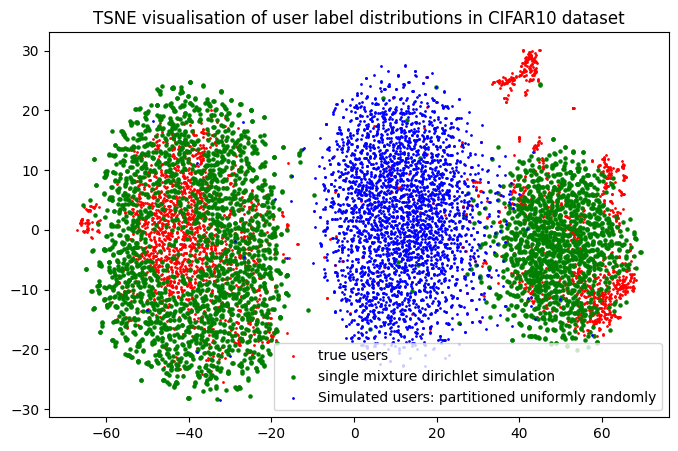

In [38]:
# Load two component mixture dirichlet saved params
params = joblib.load(os.path.join('mle_params', 'femnist_learn_dirichlet_uniform_datapoints_2_mixture', 'polya-mixture.joblib'))
print(params.keys())
alpha_mixture =  np.array(params['alphas'])
print('alpha_mixture', alpha_mixture)
phi_mixture = np.array(params['phi'])
phi_mixture /= sum(phi_mixture)
print('phi_mixture', phi_mixture)

num_samples_distribution_mixture = joblib.load(os.path.join('num_samples_distribution', 'femnist_learn_dirichlet_uniform_datapoints_2_mixture.joblib'))
num_samples_distribution_mixture = num_samples_distribution_mixture.numpy()
print('num_samples_distribution_mixture', num_samples_distribution_mixture.shape)
print(phi_mixture.shape, alpha_mixture.shape, num_samples_distribution_mixture.shape)

# generate users
numpy_to_tensor=lambda x: x
train_h5_file_path = os.path.join(data_dir, 'fed_emnist_train.h5')
true_users = generate_true_users(train_h5_file_path, numpy_to_tensor)
simulated_dirichlet_mixture_users = generate_mixture_users(len(true_users), alpha_mixture, phi_mixture, num_samples_distribution_mixture, all_labels)
len_sampler = get_femnist_len_sampler(user_id_to_data)
simulated_uniform_users = generate_uniform_users(len(true_users), len_sampler, all_labels)

# Run TSNE on the label counts of all users
tsne2 = TSNE(n_components=2)
X = np.vstack([true_users, simulated_dirichlet_mixture_users, simulated_uniform_users]) 
X = X / X.sum(axis=1, keepdims=True) # This will normalize the counts to proportions to ignore num sample per user effects
X_2dim = tsne2.fit_transform(X)

# plot
N = num_users
plt.figure(figsize=(8, 5))
plt.title('TSNE visualisation of user label distributions in CIFAR10 dataset')
plt.scatter(X_2dim[:N, 0], X_2dim[:N, 1], s=1, color='red', label='true users')
plt.scatter(X_2dim[N:2*N, 0], X_2dim[N:2*N, 1], s=5, color='green', label='single mixture dirichlet simulation')
plt.scatter(X_2dim[2*N:3*N, 0], X_2dim[2*N:3*N, 1], s=1, color='blue', label='Simulated users: partitioned uniformly randomly')
plt.legend(fontsize=10)

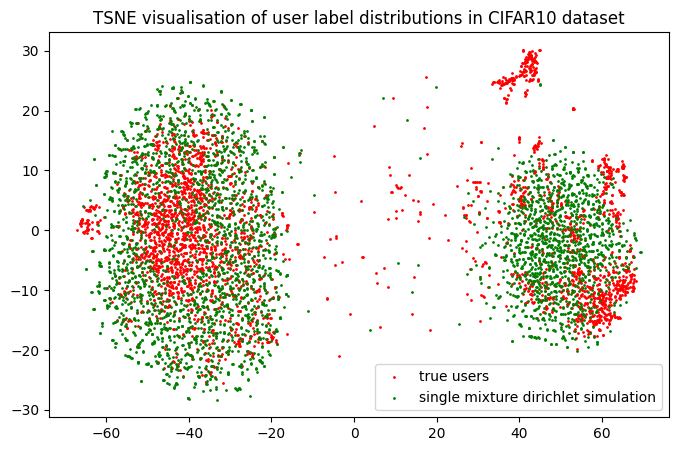

In [41]:
# plot
N = num_users
plt.figure(figsize=(8, 5))
plt.title('TSNE visualisation of user label distributions in CIFAR10 dataset')
plt.scatter(X_2dim[:N, 0], X_2dim[:N, 1], s=1, color='red', label='true users')
plt.scatter(X_2dim[N:2*N, 0], X_2dim[N:2*N, 1], s=1, color='green', label='single mixture dirichlet simulation')
#plt.scatter(X_2dim[2*N:3*N, 0], X_2dim[2*N:3*N, 1], s=1, color='blue', label='Simulated users: partitioned uniformly randomly')
plt.legend(fontsize=10)

# Three mixture components

dict_keys(['alphas', 'phi'])
alpha_mixture [[ 7.331553    7.954057    6.9863634   7.491554    6.840809    6.176658
   7.037211    7.3866696   7.0418634   7.0186877   1.7180551   1.3936192
   4.336823    1.3972884   1.021399    3.9414258   0.8377679   0.8865488
   4.666944    1.3927824   0.82493305  1.5903513   4.075701    2.323618
  11.663883    3.662332    0.8683789   0.9965437   9.724308    3.1967835
   5.7382493   1.7378958   1.9411799   0.8642131   1.9035438   0.8644596
   4.9368877   2.3315918   0.90976584  5.0233307  12.5443945   0.7650201
   1.4112251   4.09973     0.91791886  0.70593554  0.8813811   5.6781783
   0.82670665  5.477468    0.91935456  0.7856333   1.1689324   7.026988
   0.83059084  9.19348     0.8955782   0.8933723   0.8802291   0.93215483
   0.79196453  0.9271174 ]
 [18.83051    21.391619   19.192364   19.395418   18.862967   18.080807
  19.338434   20.053724   18.768417   19.05818     1.8996079   1.8278965
   2.0523577   1.8387978   1.6229041   1.7828559   1.7393

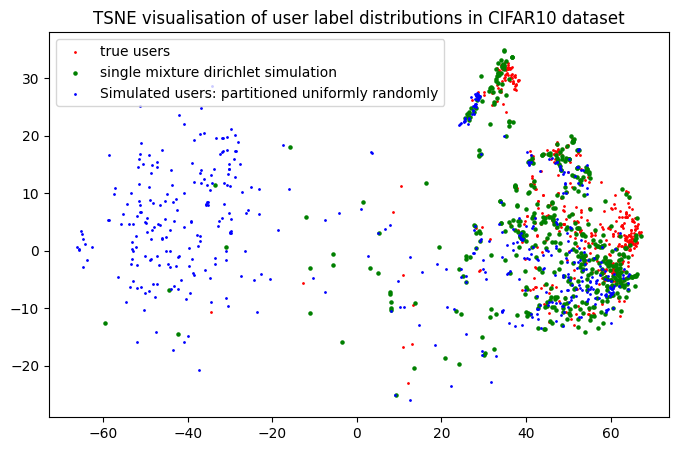

In [18]:
# Load three component mixture dirichlet saved params
num_mixture_components = 3

params = joblib.load(os.path.join('mle_params', f'femnist_{num_mixture_components}_mixture', 'polya-mixture.joblib'))
print(params.keys())
alpha_mixture =  np.array(params['alphas'])
print('alpha_mixture', alpha_mixture)
phi_mixture = np.array(params['phi'])
phi_mixture /= sum(phi_mixture)
print('phi_mixture', phi_mixture)

num_samples_distribution_mixture = joblib.load(os.path.join('num_samples_distribution', f'femnist_{num_mixture_components}_mixture.joblib'))
num_samples_distribution_mixture = num_samples_distribution_mixture.numpy()
print('num_samples_distribution_mixture', num_samples_distribution_mixture.shape)
print(phi_mixture.shape, alpha_mixture.shape, num_samples_distribution_mixture.shape)

# generate users
num_users = 500
true_users = generate_true_users(user_id_to_data)
simulated_dirichlet_mixture_users = generate_mixture_users(len(true_users), alpha_mixture, phi_mixture, num_samples_distribution_mixture, all_labels)
len_sampler = get_femnist_len_sampler(user_id_to_data)
simulated_uniform_users = generate_uniform_users(len(true_users), len_sampler, all_labels)

# Run TSNE on the label counts of all users
tsne2 = TSNE(n_components=2)
X = np.vstack([true_users, simulated_dirichlet_mixture_users, simulated_uniform_users]) 
X = X / X.sum(axis=1, keepdims=True) # This will normalize the counts to proportions to ignore num sample per user effects
X_2dim = tsne2.fit_transform(X)

# plot
N = num_users
plt.figure(figsize=(8, 5))
plt.title('TSNE visualisation of user label distributions in CIFAR10 dataset')
plt.scatter(X_2dim[:N, 0], X_2dim[:N, 1], s=1, color='red', label='true users')
plt.scatter(X_2dim[N:2*N, 0], X_2dim[N:2*N, 1], s=5, color='green', label='single mixture dirichlet simulation')
plt.scatter(X_2dim[2*N:3*N, 0], X_2dim[2*N:3*N, 1], s=1, color='blue', label='Simulated users: partitioned uniformly randomly')
plt.legend(fontsize=10)

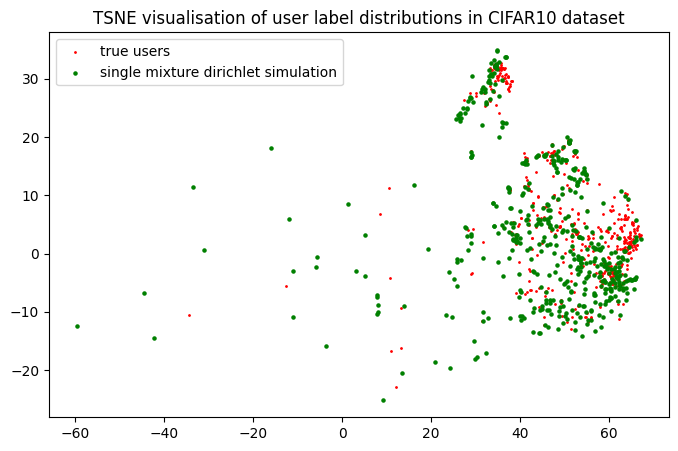

In [19]:
N = num_users
plt.figure(figsize=(8, 5))
plt.title('TSNE visualisation of user label distributions in CIFAR10 dataset')
plt.scatter(X_2dim[:N, 0], X_2dim[:N, 1], s=1, color='red', label='true users')
plt.scatter(X_2dim[N:2*N, 0], X_2dim[N:2*N, 1], s=5, color='green', label='single mixture dirichlet simulation')
#plt.scatter(X_2dim[2*N:3*N, 0], X_2dim[2*N:3*N, 1], s=1, color='blue', label='Simulated users: partitioned uniformly randomly')
plt.legend(fontsize=10)